In [1]:
import ROOT as R
from array import array
R.gROOT.SetBatch(True)

Welcome to JupyROOT 6.28/00


In [12]:
# Global variables
SIGNAL = "MHc-160_MA-85"
ERA = "2018"
CHANNEL = "Skim3Mu"
NETWORK = "GraphNet"

# List of backgrounds
nonprompt = ["nonprompt"]
conversion = ["DYJets", "DYJets10to50_MG", "ZGToLLG"]
diboson = ["WZTo3LNu_amcatnlo", "ZZTo4L_powheg"]
ttX = ["ttWToLNu", "ttZToLLNuNu", "ttHToNonbb"]
others = ["GluGluHToZZTo4L", "VBF_HToZZTo4L",
          "WWW", "WWZ", "WZZ", "ZZZ", "WWG",
          "tZq", "tHq", "TTG", "TTTT"]
backgrounds = nonprompt + conversion + diboson + ttX + others

# fit results
sigma_dict = {65: 0.76,
              85: 1.03,
              90: 1.08,
              95: 1.19,
              120: 1.58}

In [13]:
def getScoreDistribution(sampleName):
    mA = int(SIGNAL.split("_")[1].split("-")[1])
    sigma = sigma_dict[mA]
    
    filepath = ""
    if sampleName == SIGNAL:
        filepath = f"/home/choij/workspace/ChargedHiggsAnalysis/data/PromptUnbinned/{ERA}/{CHANNEL}__{NETWORK}__/PromptUnbinned_TTToHcToWAToMuMu_{SIGNAL}.root" 
    elif sampleName == "nonprompt":
        filepath = f"/home/choij/workspace/ChargedHiggsAnalysis/data/MatrixUnbinned/{ERA}/{CHANNEL}__{NETWORK}__/DATA/MatrixUnbinned_SkimTree_SS2lOR3l_DoubleMuon.root"
    else:
        filepath = f"/home/choij/workspace/ChargedHiggsAnalysis/data/PromptUnbinned/{ERA}/{CHANNEL}__{NETWORK}__/PromptUnbinned_SkimTree_SS2lOR3l_{sampleName}.root"
    f = R.TFile(filepath)
    tree = f.Get("Events_Central")
    
    mass1 = array("d", [0.]);       tree.SetBranchAddress("mass1", mass1)
    mass2 = array("d", [0.]);       tree.SetBranchAddress("mass2", mass2)
    scoreX = array("d", [0.]);      tree.SetBranchAddress(f"score_{SIGNAL}_vs_nonprompt", scoreX)
    scoreY = array("d", [0.]);      tree.SetBranchAddress(f"score_{SIGNAL}_vs_ttZ", scoreY)
    weight = array("d", [0.]);      tree.SetBranchAddress("weight", weight)
    
    h = R.TH2D(f"score_{sampleName}", "", 100, 0., 1., 100, 0., 1.)
    for evt in range(tree.GetEntries()):
        tree.GetEntry(evt)
        condition = (mA - 5*sigma < mass1[0] < mA + 5*sigma) or (mA - 5*sigma < mass2[0] < mA + 5*sigma)
        if not condition: continue
        
        h.Fill(scoreX[0], scoreY[0], weight[0])
    h.SetDirectory(0)
    f.Close()
    return h

In [14]:
h_sig = getScoreDistribution(SIGNAL)

h_bkg = None
for bkg in backgrounds:
    h = getScoreDistribution(bkg)
    if h_bkg is None: h_bkg = h.Clone("score_bkg")
    else:             h_bkg.Add(h)
    
h_nonprompt = None
for bkg in nonprompt:
    h = getScoreDistribution(bkg)
    if h_nonprompt is None: h_nonprompt = h.Clone("score_nonprompt")
    else:                   h_nonprompt.Add(h)
    
h_diboson = None
for bkg in diboson:
    h = getScoreDistribution(bkg)
    if h_diboson is None: h_diboson = h.Clone("score_diboson")
    else:                 h_diboson.Add(h)

h_ttX = None
for bkg in ttX:
    h = getScoreDistribution(bkg)
    if h_ttX is None: h_ttX = h.Clone("score_ttX")
    else:             h_ttX.Add(h)
    
h_others = None
for bkg in others:
    h = getScoreDistribution(bkg)
    if h_others is None: h_others = h.Clone("score_others")
    else:                h_others.Add(h)
    
print(f"corr signal: {h_sig.GetCorrelationFactor()}")
print(f"corr nonprompt: {h_nonprompt.GetCorrelationFactor()}")
print(f"corr diboson: {h_diboson.GetCorrelationFactor()}")
print(f"corr ttX: {h_ttX.GetCorrelationFactor()}")
print(f"corr others: {h_others.GetCorrelationFactor()}")
print(f"corr total bkg: {h_bkg.GetCorrelationFactor()}")


corr signal: -0.20121968857137598
corr nonprompt: -0.37411769727219146
corr diboson: -0.20045754503157992
corr ttX: -0.281062704103526
corr others: -0.28052280546716657
corr total bkg: -0.4427787421194491


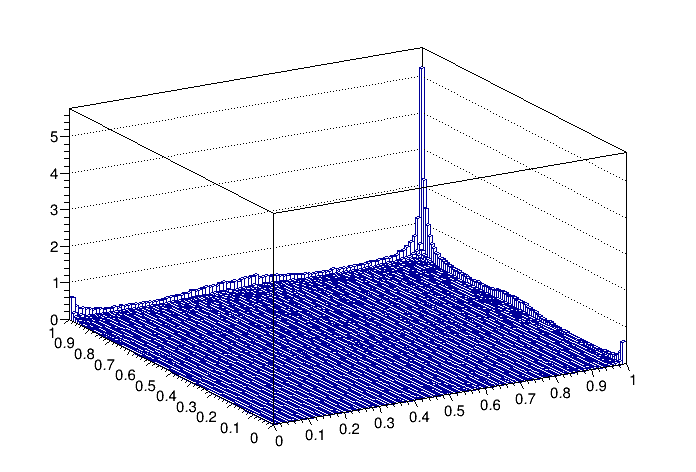

In [15]:
h_sig.SetStats(0)
c = R.TCanvas()
c.cd()
h_sig.Draw("LEGO")
c.Draw()

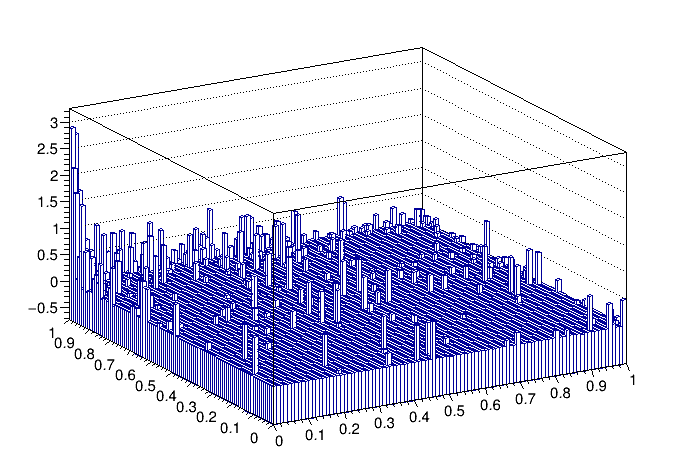

In [16]:
h_nonprompt.SetStats(0)
c = R.TCanvas()
c.cd()
h_nonprompt.Draw("LEGO")
c.Draw()

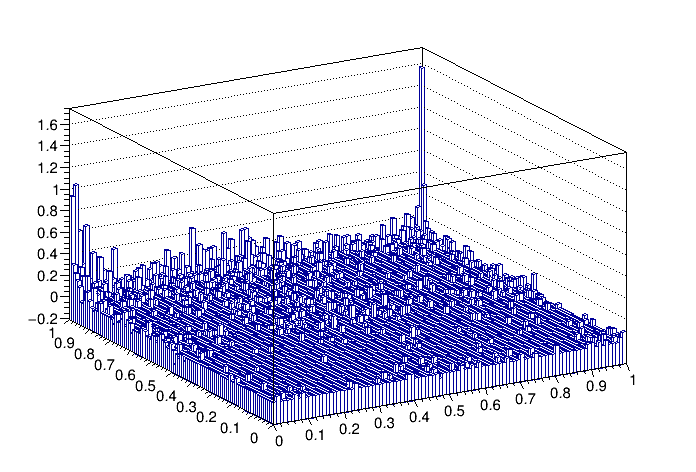

In [17]:
h_diboson.SetStats(0)
c = R.TCanvas()
c.cd()
h_diboson.Draw("LEGO")
c.Draw()

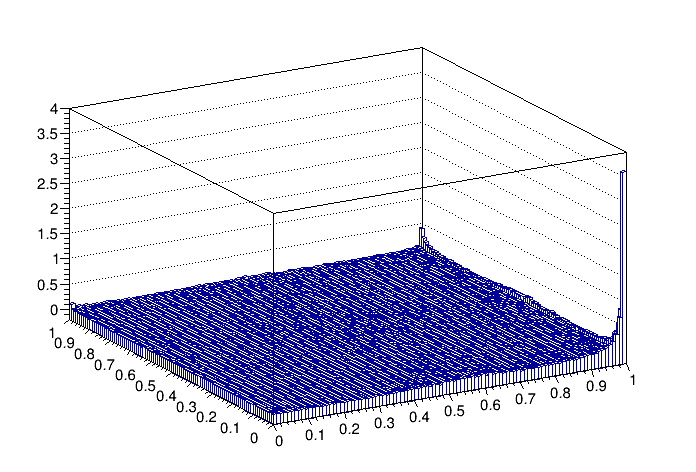

In [18]:
h_ttX.SetStats(0)
c = R.TCanvas()
c.cd()
h_ttX.Draw("LEGO")
c.Draw()

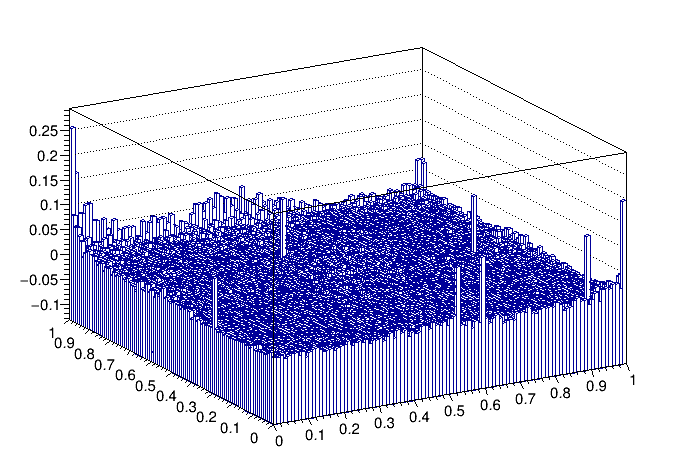

In [19]:
h_others.SetStats(0)
c = R.TCanvas()
c.cd()
h_others.Draw("LEGO")
c.Draw()

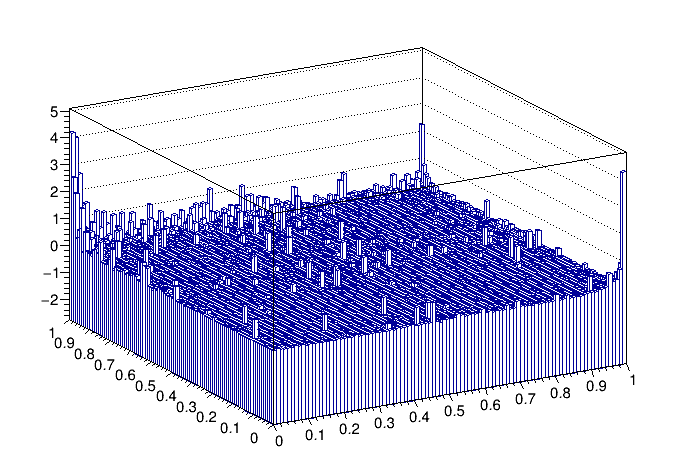

In [20]:
h_bkg.SetStats(0)
c = R.TCanvas()
c.cd()
h_bkg.Draw("LEGO")
c.Draw()

In [21]:
from itertools import product
from math import sqrt, log
nbinsX = h_sig.GetNbinsX()
nbinsY = h_sig.GetNbinsY()

nSig = h_sig.Integral(0, nbinsX+1, 0, nbinsY+1) / 3
nBkg = h_bkg.Integral(0, nbinsX+1, 0, nbinsY+1)
initMetric = sqrt(2*((nSig+nBkg)*log(1+nSig/nBkg)-nSig))
print(initMetric)

bestBinX = 0
bestBinY = 0
bestMetric = initMetric
for binX, binY in product(range(nbinsX+1), range(nbinsY+1)):
    nSig = h_sig.Integral(binX, nbinsX, binY, nbinsY) / 3
    nBkg = h_bkg.Integral(binX, nbinsX, binY, nbinsY)
    metric = sqrt(2*((nSig+nBkg)*log(1+nSig/nBkg)-nSig))
    
    if metric > bestMetric:
        bestBinX = binX
        bestBinY = binY
        bestMetric = metric
print(bestBinX, bestBinY, bestMetric)
print((bestMetric-initMetric) / initMetric)

2.422914926580492
42 8 2.751992210304986
0.13581875290558687
